In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


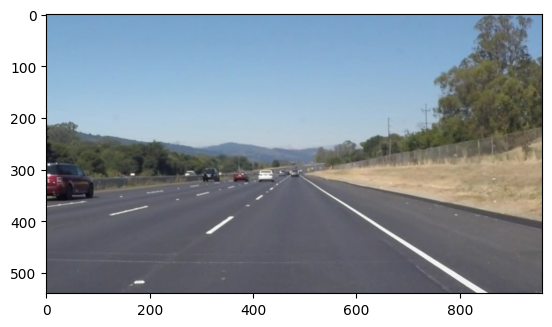

In [3]:
#reading in an image
image = mpimg.imread(r'C:\Users\Yatharth\Desktop\desktop1\AI\revoltronX\opencv_approacj\road_lane_line_detection\test_images\solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [19]:
import math

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    """
    
    mask = np.zeros_like(img)   
    
   
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
   
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image





from scipy.optimize import curve_fit

def draw_lines(img, lines, color=[255, 0, 0], thickness=5, max_degree=2):
    if lines is None:
        return
    if len(lines) == 0:
        return

    slope_threshold = 0.5
    slopes = []
    new_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 == 0.:  
            slope = 999.  
        else:
            slope = (y2 - y1) / (x2 - x1)
        
        if abs(slope) > slope_threshold:
            slopes.append(slope)
            new_lines.append(line)
    
    lines = new_lines
    right_lines = []
    left_lines = []
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        img_x_center = img.shape[1] / 2 
        if slopes[i] > 0 and x1 > img_x_center and x2 > img_x_center:
            right_lines.append(line)
        elif slopes[i] < 0 and x1 < img_x_center and x2 < img_x_center:
            left_lines.append(line)

    # Fit a polynomial of variable degree
    def fit_poly(lines, max_degree):
        x_coords = []
        y_coords = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            x_coords.extend([x1, x2])
            y_coords.extend([y1, y2])
        
        if len(x_coords) > 0:
            
            best_fit = None
            best_degree = 1
            lowest_error = float('inf')
            for degree in range(1, max_degree + 1):
                poly_coeffs = np.polyfit(y_coords, x_coords, degree)
                poly_func = np.poly1d(poly_coeffs)
                error = np.mean((poly_func(y_coords) - x_coords) ** 2)
                if error < lowest_error:
                    lowest_error = error
                    best_fit = poly_coeffs
                    best_degree = degree
            return best_fit, best_degree
        else:
            return None, None

    right_fit, right_degree = fit_poly(right_lines, max_degree)
    left_fit, left_degree = fit_poly(left_lines, max_degree)

    # Function to calculate x from y using the polynomial coefficients
    def poly(x, coeffs):
        return np.polyval(coeffs, x)

    # Draw the polynomial lines
    def draw_poly_line(coeffs, img, y1, y2, color, thickness, degree):
        if coeffs is not None:
            y_vals = np.linspace(y1, y2, num=100)  # Generate 100 y points
            x_vals = poly(y_vals, coeffs)
            line_points = np.array([x_vals, y_vals], dtype=np.int32).T  # Transpose to get pairs
            cv2.polylines(img, [line_points], isClosed=False, color=color, thickness=thickness)
            eq_text = f"y = {np.poly1d(coeffs)}"
            cv2.putText(img, eq_text, (50, 50 if coeffs is right_fit else 100), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            degree_text = f"Degree: {degree}"
            cv2.putText(img, degree_text, (50, 75 if coeffs is right_fit else 125), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    y1 = img.shape[0]
    y2 = int(img.shape[0] * (1 - trap_height))
    draw_poly_line(right_fit, img, y1, y2, color, thickness, right_degree)
    draw_poly_line(left_fit, img, y1, y2, color, thickness, left_degree)





    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros(img.shape, dtype=np.uint8)  # this produces single-channel (grayscale) image
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)  # 3-channel RGB image
    draw_lines(line_img, lines)
    #draw_lines_debug2(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):

    return cv2.addWeighted(initial_img, α, img, β, λ)


def filter_colors(image):
    """
    Filter the image to include only yellow and white pixels
    """
    # Filter white pixels
    white_threshold = 200
    lower_white = np.array([white_threshold, white_threshold, white_threshold])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(image, lower_white, upper_white)
    white_image = cv2.bitwise_and(image, image, mask=white_mask)

    # Filter yellow pixels
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([110,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(image, image, mask=yellow_mask)

    # Combine the two above images
    image2 = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)

    return image2

In [7]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteCurve_annotated.jpg',
 'solidWhiteCurve_annotated_annotated.jpg',
 'solidWhiteCurve_annotated_annotated_annotated.jpg',
 'solidWhiteCurve_annotated_annotated_annotated_annotated.jpg',
 'solidWhiteCurve_annotated_annotated_annotated_annotated_annotated.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteRight_annotated.jpg',
 'solidWhiteRight_annotated_annotated.jpg',
 'solidWhiteRight_annotated_annotated_annotated.jpg',
 'solidWhiteRight_annotated_annotated_annotated_annotated.jpg',
 'solidWhiteRight_annotated_annotated_annotated_annotated_annotated.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve2_annotated.jpg',
 'solidYellowCurve2_annotated_annotated.jpg',
 'solidYellowCurve2_annotated_annotated_annotated.jpg',
 'solidYellowCurve2_annotated_annotated_annotated_annotated.jpg',
 'solidYellowCurve2_annotated_annotated_annotated_annotated_annotated.jpg',
 'solidYellowCurve_annotated.jpg',
 'solidYellowCurve_annotated_annotated.jpg',
 

run your solution on all test_images and make copies into the test_images directory).

In [20]:
# Global parameters

# Gaussian smoothing
kernel_size = 3

# Canny Edge Detector
low_threshold = 50
high_threshold = 150

# Region-of-interest vertices
# We want a trapezoid shape, with bottom edge at the bottom of the image
trap_bottom_width = 0.85  # width of bottom edge of trapezoid, expressed as percentage of image width
trap_top_width = 0.07  # ditto for top edge of trapezoid
trap_height = 0.4  # height of the trapezoid expressed as percentage of image height

# Hough Transform
rho = 2 # distance resolution in pixels of the Hough grid
theta = 1 * np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments

In [21]:
def annotate_image(image_in):
    """ Given an image Numpy array, return the annotated image as a Numpy array """
    # Only keep white and yellow pixels in the image, all other pixels become black
    image = filter_colors(image_in)
    
    # Read in and grayscale the image
    #image = (image*255).astype('uint8')  # this step is unnecessary now
    gray = grayscale(image)

    # Apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, kernel_size)

    # Apply Canny Edge Detector
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Create masked edges using trapezoid-shaped region-of-interest
    imshape = image.shape
    vertices = np.array([[\
        ((imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0]),\
        ((imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_top_width)) // 2, imshape[0] - imshape[0] * trap_height),\
        (imshape[1] - (imshape[1] * (1 - trap_bottom_width)) // 2, imshape[0])]]\
        , dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Run Hough on edge detected image
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Draw lane lines on the original image
    initial_image = image_in.astype('uint8')
    annotated_image = weighted_img(line_image, initial_image)
    
    return annotated_image

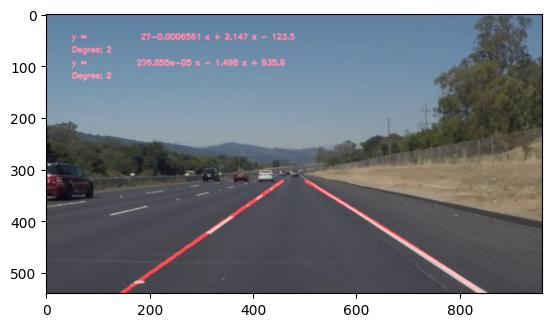

In [22]:
annotated_image = annotate_image(mpimg.imread(r'C:\Users\Yatharth\Desktop\desktop1\AI\revoltronX\opencv_approacj\road_lane_line_detection\test_images\solidWhiteRight.jpg'))
plt.imshow(annotated_image)

In [23]:

test_images = os.listdir('test_images/')

for image in test_images:
    annotated_image = annotate_image(mpimg.imread((os.path.join('test_images', image))))
    fname = image.split('.')[0] + '_annotated.jpg'  # add '_annotated' suffix to annotated image jpg file
    plt.imsave(os.path.join('test_images', fname), annotated_image)

In [24]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
def process_image(image):
    result = annotate_image(image)

    return result

Let's try the one with the solid white lane on the right first ...

In [26]:
white_output = r'C:\Users\Yatharth\Desktop\desktop1\AI\revoltronX\opencv_approacj\output_video_new.mp4'
clip1 = VideoFileClip(r"C:\Users\Yatharth\Desktop\desktop1\AI\revoltronX\opencv_approacj\output_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video C:\Users\Yatharth\Desktop\desktop1\AI\revoltronX\opencv_approacj\output_video_new.mp4.
Moviepy - Writing video C:\Users\Yatharth\Desktop\desktop1\AI\revoltronX\opencv_approacj\output_video_new.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Yatharth\Desktop\desktop1\AI\revoltronX\opencv_approacj\output_video_new.mp4
CPU times: total: 453 ms
Wall time: 4.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [28]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video yellow.mp4.
Moviepy - Writing video yellow.mp4



Moviepy - Done !
Moviepy - video ready yellow.mp4
CPU times: total: 859 ms
Wall time: 8.31 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))